In [49]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pylab

In [5]:
root = os.getcwd()
data_root = os.path.join(root, 'data')

In [7]:
train_data = pd.read_csv(os.path.join(data_root, 'training_v2.csv.zip'))

In [14]:
dictionary = pd.read_csv(os.path.join(data_root, 'WiDS Datathon 2020 Dictionary.csv'))

In [33]:
train_data.shape

(91713, 186)

In [24]:
train_data.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
train_data.isnull().sum()

encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64

### Age

In [48]:
?sns.distplot

(array([ 2271.,  2981.,  3538.,  5314.,  8002., 11824., 15944., 14264.,
        12670., 10677.]),
 array([16. , 23.3, 30.6, 37.9, 45.2, 52.5, 59.8, 67.1, 74.4, 81.7, 89. ]),
 <a list of 10 Patch objects>)

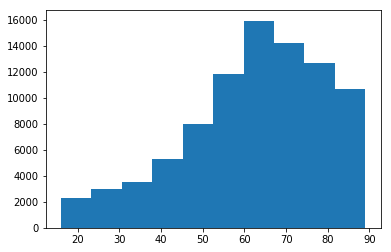

In [51]:
pylab.hist(train_data[~np.isnan(train_data['age'])]['age'])

In [ ]:
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)